In [16]:
from pathlib import Path
import math
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [2]:
molecules= pd.read_csv("Aromatase_bioactivity_and_drugs")
molecules.head()

,molecule_chembl_id,IC50,units,smiles,PIC50,ROMol
0,CHEMBL1672980,0.015,nM,COc1ccc(-c2cc(N(Cc3ccc(OS(N)(=O)=O)cc3)n3cnnc3...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...
1,CHEMBL1672978,0.015,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...
2,CHEMBL1672979,0.018,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Br)c2)n2cnnc2)...,10.744727,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...
3,CHEMBL310735,0.037,nM,C[C@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.431798,<rdkit.Chem.rdchem.Mol object at 0x0000023573D...
4,CHEMBL305205,0.049,nM,C[C@@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.309804,<rdkit.Chem.rdchem.Mol object at 0x0000023573D...



Lipiniski rule of five:

    Molecular weight (MWT) <= 500 Da

    Number of hydrogen bond acceptors (HBAs) <= 10

    Number of hydrogen bond donors (HBD) <= 5

    Calculated LogP (octanol-water coefficient) <= 5


#### Calculate compliance with lipinski ro5.

In [3]:
def calculate_ro5_properties(smiles):
    
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )



In [4]:
# Apply the Ro5 to all molecules.

ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,476.126674,9,1,2.87758,True
1,480.077137,8,1,3.52238,True
2,524.026622,8,1,3.63148,True
3,286.229666,1,0,5.15440,True
4,286.229666,1,0,5.15440,True


In [5]:
ro5_properties.shape

(1798, 5)

In [6]:
# Concatenate molecules with Ro5 data.
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()


,molecule_chembl_id,IC50,units,smiles,PIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL1672980,0.015,nM,COc1ccc(-c2cc(N(Cc3ccc(OS(N)(=O)=O)cc3)n3cnnc3...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...,476.126674,9,1,2.87758,True
1,CHEMBL1672978,0.015,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...,480.077137,8,1,3.52238,True
2,CHEMBL1672979,0.018,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Br)c2)n2cnnc2)...,10.744727,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...,524.026622,8,1,3.63148,True
3,CHEMBL310735,0.037,nM,C[C@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.431798,<rdkit.Chem.rdchem.Mol object at 0x0000023573D...,286.229666,1,0,5.15440,True
4,CHEMBL305205,0.049,nM,C[C@@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.309804,<rdkit.Chem.rdchem.Mol object at 0x0000023573D...,286.229666,1,0,5.15440,True


In [7]:
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 1798
# compounds in filtered data set: 1742
# compounds not compliant with the Ro5: 56


In [8]:
# Save filtered data
molecules_ro5_fulfilled.to_csv("Aromatase_compounds_lipinski.csv")

In [9]:
# Calculate statistics on Ro5 properties.
def calculate_mean_std(dataframe):
   
    stats = dataframe.describe()
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [10]:
#statistics for the dataset of compounds that are fulfilling the Ro5.
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]])


molecules_ro5_fulfilled_stats

,mean,std
molecular_weight,320.143219,69.775255
n_hba,3.856487,1.802118
n_hbd,0.602755,0.885491
logp,3.683496,1.163733


In [11]:
#statistics for the dataset of compounds that are violating the Ro5.
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]])

molecules_ro5_violated_stats

,mean,std
molecular_weight,706.638775,138.762118
n_hba,7.089286,2.937388
n_hbd,4.160714,1.904796
logp,6.303456,2.879833


#### prepare data for radar plotting:

    scaled MWT = MWT / 500 * 5 = MWT / 100

    scaled HBA = HBA / 10 * 5 = HBA / 2

    scaled HBD = HBD / 5 * 5 = HBD

    scaled LogP = LogP / 5 * 5 = LogP


In [13]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles


def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
    ):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

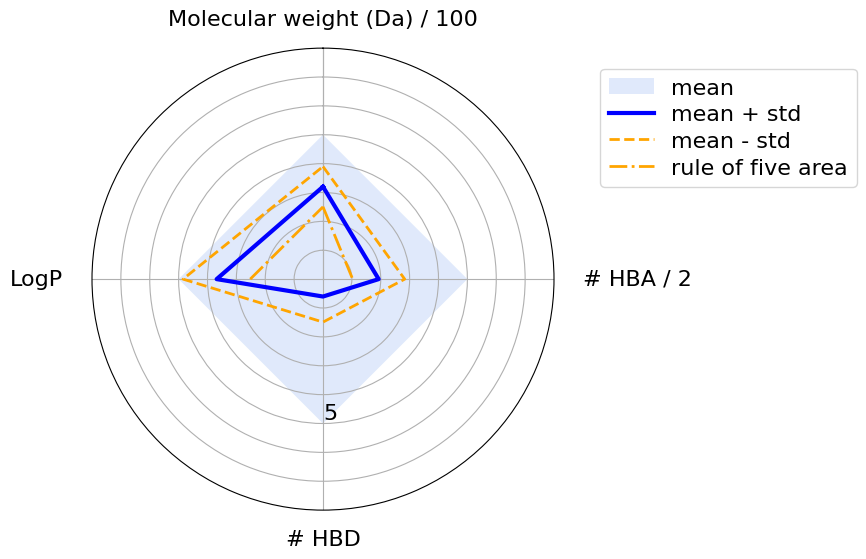

In [14]:
# Define input parameters that should stay the same for both radar charts.
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

# plot the radarplot for the dataset of compounds that fulfill the Ro5.

plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,)


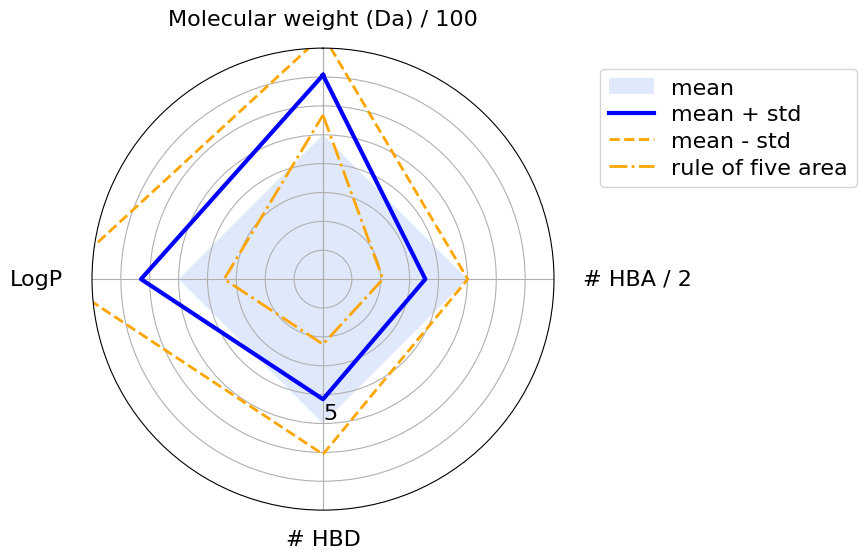

In [15]:
# plot the radarplot for the dataset of compounds that violate the Ro5.
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,)


### Molecular filtering: unwanted substructures.

In [22]:
molecules_data = pd.read_csv("Aromatase_compounds_lipinski.csv")

In [23]:
print("Dataframe shape:", molecules_data.shape)

molecules_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
molecules_data.head(2)

Dataframe shape: (1742, 12)


,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,PIC50,ROMol,ro5_fulfilled
0,0,CHEMBL1672980,0.015,nM,COc1ccc(-c2cc(N(Cc3ccc(OS(N)(=O)=O)cc3)n3cnnc3...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...,True
1,1,CHEMBL1672978,0.015,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...,True


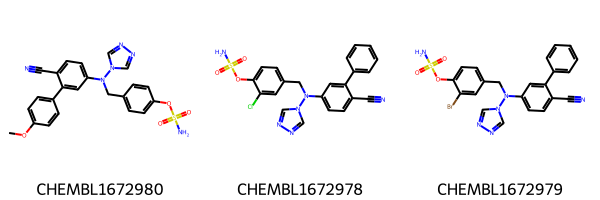

In [24]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(molecules_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(molecules_data.head(3).ROMol),
    legends=list(molecules_data.head(3).molecule_chembl_id),
)


Filter for PAINS.

The PAINS filter is already implemented in RDKit via the FilterCatalog class.

In [25]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)


# search for PAINS
matches = []
clean = []
for index, row in tqdm(molecules_data.iterrows(), total=molecules_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = molecules_data.loc[clean]  # keep molecules without PAINS


print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(molecules_data)}")

  0%|          | 0/1742 [00:00<?, ?it/s]

Number of compounds with PAINS: 49
Number of compounds without PAINS: 1742


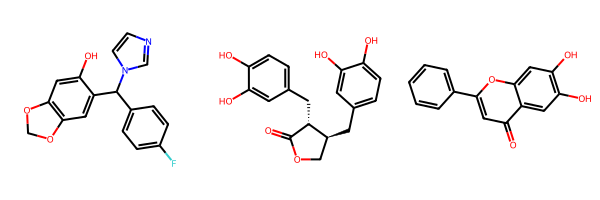

In [27]:
# the first 3 identified PAINS.

Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    )
